# **GIS × Python Tutorial Session6 ~ Lidarデータことはじめ ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
**`Lidar（Light Detection and Ranging、Laser Imaging Detection and Ranging）`** とは、レーザー（光）を用いて対象までの距離や性質を分析するものです。Lidarで取得したデータには 'x', 'y', 'z' 座標の他に '反射強度' などが含まれています。

ドローンや航空機などで取得した3次元点群データは、詳細な地形や地物の把握などに使用されており、目にする機会が増えて来た様に思います。実際にこの記事を書いている私自身、仕事で少し触る機会があり、この記事を書くきっかけにもなりました。

この題材も少し長くなりそうなので、複数に記事を分けて書きますが、今回ははじめの一歩という事で以下の項目について解説します。

 - 点群データ処理のライブラリー

 - 今回使用するデータ

 - '.las'ファイルの読み込みと概要の確認
 
 - データ範囲の確認

 - 空間参照系の定義

 - 点群データのビジュアライズ

 - 外れ値の除去

 - 新たなファイルへの書き込み

<br><br><br>



## **点群データ処理のライブラリー**
---
今回、点群データを処理するライブラリーとして、 **`PDAL（Point Data Abstraction Library）`** を使用します。PDALはCLIで操作する方が一般的かもしれませんが、今回はPython APIを使用して、Notebook内で完結させます。

PDALは、点群データを変換および操作する為のC++のライブラリーです。PDALは様々なフォーマットのデータを読み書きする事が可能であり、ラスターデータとして出力する事もできます。

PDALは処理の流れを "Pipeline" として記述する事で、'読み込み' -> 'データ処理' -> '書き込み' というワークフローを作成し実行します。

PDALをPythonの環境にインストールするには "Anaconda" を使用するのが簡単です。個人的な経験上では、GIS系のライブラリーは喧嘩する事が多く、今回は "pyproj" あたりと喧嘩しているようで、なんとか作成したyamlファイルをGitHubに公開してあるので、そちらを使用してください。GoogleColabでのインストール方法もGitHubに載せておきます。

<br><br><br>



## **今回使用するデータ**
---
今回は "オープンナガサキ" からダウンロードした '.las' データを使用します。グリッドのIDは "01ID7913" です。空間参照系は「世界測地系(JGD2011)／平面直角座標系第1系（EPSG: 6669）」を使用しているようです。

<br><br><br>



## **Import modules.**
---

In [91]:
import json
import os
from pprint import pprint

import geopandas as gpd
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import seaborn as sns
import shapely
import open3d
plt.style.use('ggplot')


IN_FILE_PATH = "../datasets/01ID7913_org.las"
IN_EPSG = 'EPSG:6669'

## **ファイルの読み込みと概要の確認**
---
"Pipeline"は辞書型のオブジェクトに処理を書いて、文字列に変換し使用します。'.json'ファイルに処理の内容を書いて、それを読み込んでも構いませんが、Notebookを使用するのであれば、わざわざ'.json'に記述するのは面倒でしょう。

In [89]:
sentence = \
    {
        "pipeline": [
            # このListの中に処理を描いた辞書を追加していく
            {
                "type": "readers.las",
                "filename": IN_FILE_PATH
            }
        ]
    }
# 
js = json.dumps(sentence)
pipeline = pdal.Pipeline(js)

# Pipelineの実行
pipeline.execute()

metadata = pipeline.metadata
pprint(metadata)

{'metadata': {'filters.merge': {},
              'readers.las': {'comp_spatialreference': '',
                              'compressed': False,
                              'copc': False,
                              'count': 6684582,
                              'creation_doy': 0,
                              'creation_year': 0,
                              'dataformat_id': 2,
                              'dataoffset': 227,
                              'filesource_id': 0,
                              'global_encoding': 0,
                              'global_encoding_base64': 'AAA=',
                              'header_size': 227,
                              'major_version': 1,
                              'maxx': -3000,
                              'maxy': 38250,
                              'maxz': 1302.339999,
                              'minor_version': 2,
                              'minx': -4000,
                              'miny': 37500,
                 

上記で出力したメタデータの'spatialreference'に注目します。

In [8]:
srs = metadata.get('metadata')\
        .get('readers.las')\
        .get('spatialreference')

print(f"Spatial Reference: {srs}")

Spatial Reference: 


'spatialreference' には何も記録されていません。**`Spatial Reference System（srs: 空間参照系）`** とは現実世界の位置を特定する為のルールであり、空間参照系の種類によって、原点となる場所が異なります。

データには記録されていませんが、オープンナガサキのサイトには "世界測地系(JGD2011)／平面直角座標系第1系" と書かれていたので、"EPSG:6669" を設定しましょう。ちなみに原点は長崎県の海にあります。

今回は間違いはありませんが、どっかの誰かから貰った適当なデータなどで、空間参照系が記録されていない場合はどうしたらいいのでしょうか。
<br><br><br>


## **データ範囲の確認**
---
先ほど出力したメタデータの中には、XY座標の範囲が記録されています。それを取り出して、"geopandas.GeoDataFrame.explore" を使用し動的なマップに投影し、ダウンロードした範囲と一致するかを見てみましょう。

In [9]:
meta_data_readers = metadata.get('metadata').get('readers.las')
x_max = meta_data_readers.get('maxx')
x_min = meta_data_readers.get('minx')
y_max = meta_data_readers.get('maxy')
y_min = meta_data_readers.get('miny')

# 範囲のPolygonを作成
boundary = shapely.box(x_min, y_min, x_max, y_max)

# 
count = meta_data_readers.get('count')
report = \
f"""
計測範囲面積    : {boundary.area / 10_000}ha
計測点数        : {'{0:,}'.format(count)}
1㎡あたりの点数 : {round(count / boundary.area, 1)} 
"""
print(report)


計測範囲面積    : 75.0ha
計測点数        : 6,684,582
1㎡あたりの点数 : 8.9 



設定するSRS

In [10]:
proj_crs = pyproj.CRS(IN_EPSG)
# 今回は記事で見やすい様に"pretty=True"としていますが、普通は不要です。
IN_SRS = proj_crs.to_wkt(pretty=True)
pprint(IN_SRS)

('PROJCRS["JGD2011 / Japan Plane Rectangular CS I",\n'
 '    BASEGEOGCRS["JGD2011",\n'
 '        DATUM["Japanese Geodetic Datum 2011",\n'
 '            ELLIPSOID["GRS 1980",6378137,298.257222101,\n'
 '                LENGTHUNIT["metre",1]]],\n'
 '        PRIMEM["Greenwich",0,\n'
 '            ANGLEUNIT["degree",0.0174532925199433]],\n'
 '        ID["EPSG",6668]],\n'
 '    CONVERSION["Japan Plane Rectangular CS zone I",\n'
 '        METHOD["Transverse Mercator",\n'
 '            ID["EPSG",9807]],\n'
 '        PARAMETER["Latitude of natural origin",33,\n'
 '            ANGLEUNIT["degree",0.0174532925199433],\n'
 '            ID["EPSG",8801]],\n'
 '        PARAMETER["Longitude of natural origin",129.5,\n'
 '            ANGLEUNIT["degree",0.0174532925199433],\n'
 '            ID["EPSG",8802]],\n'
 '        PARAMETER["Scale factor at natural origin",0.9999,\n'
 '            SCALEUNIT["unity",1],\n'
 '            ID["EPSG",8805]],\n'
 '        PARAMETER["False easting",0,\n'
 '            LE

In [11]:
gdf = gpd.GeoDataFrame(geometry=[boundary], crs=IN_SRS)
gdf.explore()

間違いなさそうです。
<br><br><br>

## **座標参照系の定義**
---
データに座標参照系を定義する場合は、Pipeline処理の 'readers.xxx' にてデータを読み込む際に 'default_srs' を指定して読み込む事で定義できます。

In [12]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': IN_FILE_PATH,
                # ここでSRSを指定
                'default_srs': IN_SRS
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

# メタデータを読み込み、空間参照系が定義されているかを確認する。
metadata = pipeline.metadata
pprint(
    metadata.get('metadata')\
            .get('readers.las')\
            .get('spatialreference')
)

('PROJCRS["JGD2011 / Japan Plane Rectangular CS I",\n'
 '    BASEGEOGCRS["JGD2011",\n'
 '        DATUM["Japanese Geodetic Datum 2011",\n'
 '            ELLIPSOID["GRS 1980",6378137,298.257222101,\n'
 '                LENGTHUNIT["metre",1]]],\n'
 '        PRIMEM["Greenwich",0,\n'
 '            ANGLEUNIT["degree",0.0174532925199433]],\n'
 '        ID["EPSG",6668]],\n'
 '    CONVERSION["Japan Plane Rectangular CS zone I",\n'
 '        METHOD["Transverse Mercator",\n'
 '            ID["EPSG",9807]],\n'
 '        PARAMETER["Latitude of natural origin",33,\n'
 '            ANGLEUNIT["degree",0.0174532925199433],\n'
 '            ID["EPSG",8801]],\n'
 '        PARAMETER["Longitude of natural origin",129.5,\n'
 '            ANGLEUNIT["degree",0.0174532925199433],\n'
 '            ID["EPSG",8802]],\n'
 '        PARAMETER["Scale factor at natural origin",0.9999,\n'
 '            SCALEUNIT["unity",1],\n'
 '            ID["EPSG",8805]],\n'
 '        PARAMETER["False easting",0,\n'
 '            LE

問題なく定義できています。
<br><br><br>

## **点群データのビジュアライズ**
----
点群データをビジュアライズする為には、各点の座標が必要です。"pipeline" のインスタンスには "arrays" のメソッドがあり、Listに "numpy.ndarray" の配列を格納して取得する事が可能です。

In [13]:
arys = pipeline.arrays
arys

[array([(-3999.7200002 , 37554.73      , 249.50999987, 121, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12593, 20303, 22616),
        (-3966.03000069, 37517.36999991, 253.99999994, 122, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12079, 17733, 19018),
        (-3972.01000013, 37543.96999932, 253.37999986,  95, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 16448, 21588, 21074),
        ...,
        (-3000.        , 37897.95999958, 323.77999955,  92, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 65535, 65535, 65535),
        (-3000.16000075, 37897.93999931, 323.77999955, 167, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 22102, 26471, 24158),
        (-3000.16000075, 37912.35999957, 317.51999955,  24, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0., 0, 29, 12850, 21331, 22873)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('Synthetic', 'u1'), ('KeyPoint', 'u1'), ('Withheld', 

上記の "ary" を使用しても構いませんが、"pipeline" には "get_dataframe" メソッドも存在しており、簡単に "pandas.DataFrame" に変換する事が出来ます。

In [14]:
df = pipeline.get_dataframe(0)
df.head(2)

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,Red,Green,Blue
0,-3999.720000,37554.73,249.51,121,0,0,0,0,1,0,0,0,0,0.0,0,29,12593,20303,22616
1,-3966.030001,37517.37,254.00,122,0,0,0,0,1,0,0,0,0,0.0,0,29,12079,17733,19018


DataFrameからXYZの情報を取り出し "open3d" で点群を可視化してみましょう。

In [15]:
xyz_names = ['X', 'Y', 'Z']

point_cloud = df[xyz_names].to_numpy()
print(point_cloud.shape)
point_cloud

(6684582, 3)


array([[-3999.7200002 , 37554.73      ,   249.50999987],
       [-3966.03000069, 37517.36999991,   253.99999994],
       [-3972.01000013, 37543.96999932,   253.37999986],
       ...,
       [-3000.        , 37897.95999958,   323.77999955],
       [-3000.16000075, 37897.93999931,   323.77999955],
       [-3000.16000075, 37912.35999957,   317.51999955]])

下記のコードを実行すると、アプリが起動します。

In [16]:
visualize = open3d.geometry.PointCloud()
visualize.points = open3d.utility.Vector3dVector(point_cloud)
open3d.visualization.draw_geometries([visualize])

添付の画像内の赤丸で囲った場所に1点のみ、なぜか点があります。ぱっと見でもこれはおかしなデータだと判断できますので、次はこの外れ値を除去しましょう。

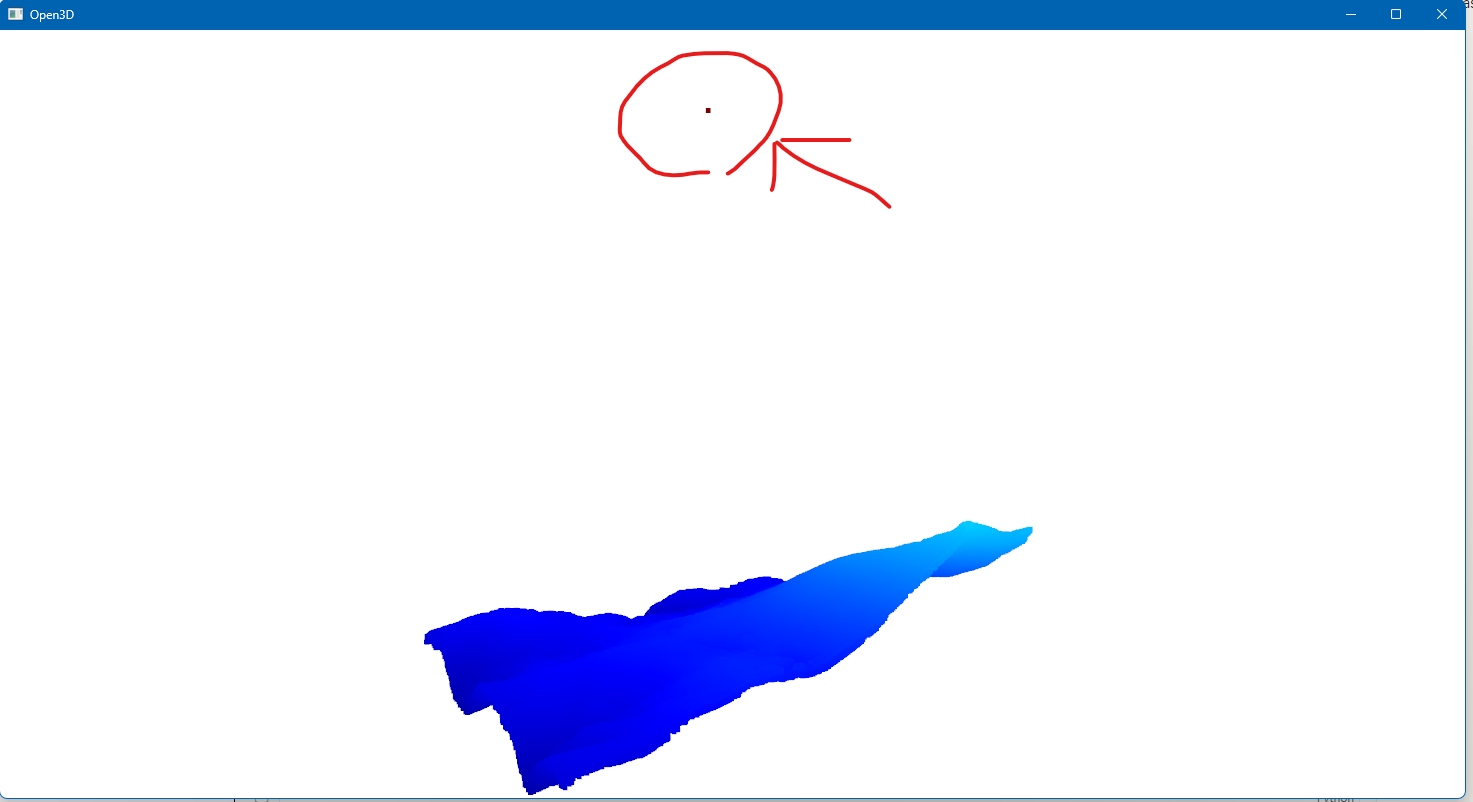

In [17]:
Image(r'../images/outlier.png')

<br><br><br>


## **外れ値の除去**
---
外れ値の除去は、"Pipeline"のワークフローに"filters"の辞書を追加して行います。

方法としては以下の2つが考えられます。

 1. **各点ごとにk個の近傍と比べて、外れ値を定義する閾値を計算する。**

      この計算は "filters.outlier" で行います。"filters.outlier"では k個の近傍の平均距離と標準偏差を計算し、外れ値を定義する閾値を計算しているようです。

      - **メリット** ...
   
         簡単に外れ値の除去を行う事が出来る。
   
      - **デメリット** ...

         今回の様に撮影範囲が森林だったりする場合は、ほとんどの点群データは樹冠にぶつかり止まります。しかし、実際に使用したいデータは樹冠だけとは限りません。地形のデータが欲しい場合にこの方法を行うと、数少ない地面のデータが外れ値として定義され、消されてしまうかもしれません。あるいは、今回の様に大きく距離が開いた外れ値があると、標準偏差が大きくなり、パラメーター設定が難しくなります。

<br>

 2. **自らデータを分析して、必要な条件式を作成する**
   
      条件式は"filters.expression"で行います。今回の様に外れ値が少なく、明らかな場合は一度こちらを試し、データをもう一度見てから "filters.outlier" を使用するかを考えると良いと思います。


      - **メリット** ...
      
         自分で条件を書くので、意図しない動きをする事はない。

      - **デメリット** ...
      
         分析が面倒。

<br>

今回はどちらも試して、どれくらい点の数が減っているのかを確認してみましょう。

<br><br>

### **filters.outlierの場合**

In [18]:
# 結構時間が掛かります。自分のPCでは1分くらいでした。
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': IN_FILE_PATH,
                'default_srs': IN_EPSG
            },
            {
                'type':'filters.outlier',
                'method': 'statistical',
                # 今回は1㎡あたり9点だったので、計算範囲をそれに合わせます。
                'mean_k': 9,
                # 平均から、標準偏差の何倍を閾値とするか。
                'multiplier': 2
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

df_outlier = pipeline.get_dataframe(idx=0)

外れ値除去前と後で点数が変化しているか確かめます。

In [32]:
print(
f"""
処理前: {'{0:,}'.format(df.shape[0])}
処理後: {'{0:,}'.format(df_outlier.shape[0])}
""")


処理前: 6,684,582
処理後: 6,684,582



外れ値処理をしましたが、データ数に変化はありません。
少しパラメーターを調整してみましょう。

In [34]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': IN_FILE_PATH,
                'default_srs': IN_EPSG
            },
            {
                'type':'filters.outlier',
                'method': 'statistical',
                'mean_k': 36,
                'multiplier': 1
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

df_outlier = pipeline.get_dataframe(idx=0)

print(
f"""
処理前: {'{0:,}'.format(df.shape[0])}
処理後: {'{0:,}'.format(df_outlier.shape[0])}
""")


処理前: 6,684,582
処理後: 6,684,582



パラメータを変化させてみましたが、外れ値は除去出来ていません。

次はデータを見て、条件式を適用してみます。
<br><br>


### **filters.expression**
条件式では、単純にデータの範囲を可視化し、外れ値のデータを見てみましょう。

In [67]:
df.describe()['Z']

count    6.684582e+06
mean     3.154099e+02
std      6.870402e+01
min      1.428500e+02
25%      2.672600e+02
50%      2.959000e+02
75%      3.566900e+02
max      1.302340e+03
Name: Z, dtype: float64


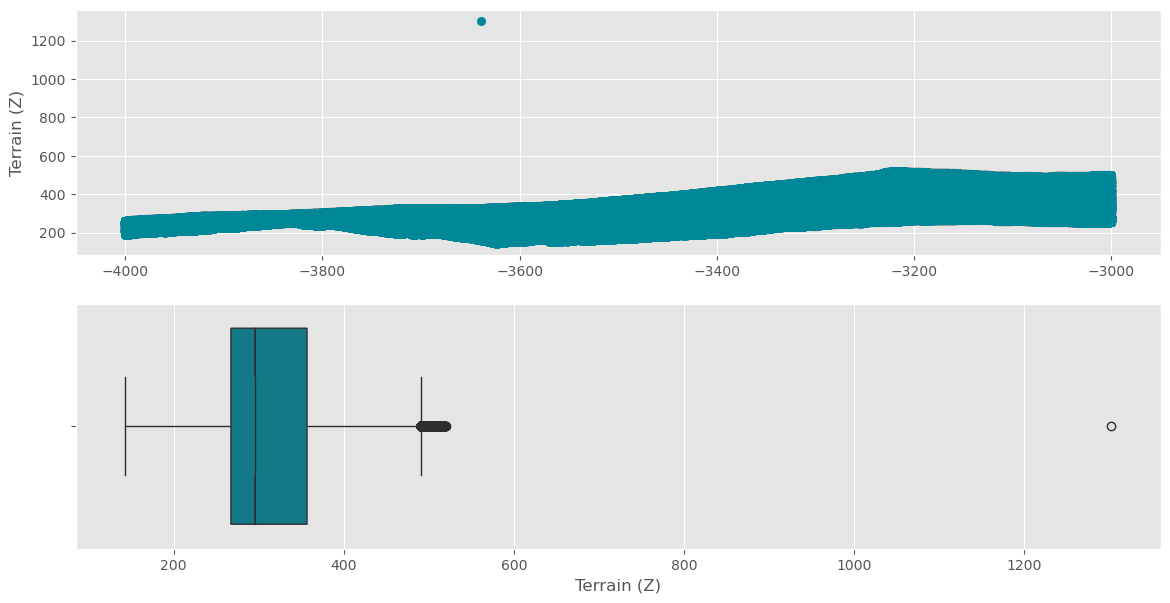

In [81]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 7))

ax[0].scatter(x=df['X'], y=df['Z'], c='#008899')
ax[0].set_ylabel('Terrain (Z)')


sns.boxplot(
    x=df["Z"], 
    color='#008899', 
    notch=True, 
    ax=ax[1]
)
ax[1].set_xlabel('Terrain (Z)');

In [83]:
_df = df[600 <= df['Z']].copy()
print(_df.shape)
_df.head(5)

(1, 19)


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,Synthetic,KeyPoint,Withheld,Overlap,ScanAngleRank,UserData,PointSourceId,Red,Green,Blue
1944,-3639.080001,37789.96,1302.339999,255,0,0,0,0,1,0,0,0,0,0.0,0,29,8224,15677,14906


ほとんどのデータが600m以内にある中、**1点だけが1300m** の高さにあります。鳥にしては高すぎる気がしますし（知りませんが...）まぁこれが外れ値として考えても問題ないでしょう。

条件式は **"filters.expression"** で適用します。

In [84]:
sentence = \
    {
        "pipeline": [
            {
                'type': 'readers.las',
                'filename': IN_FILE_PATH,
                'default_srs': IN_EPSG
            },
            {
                "type":"filters.expression",
                "expression":"(Z < 600)"
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

6684581

In [85]:
df_outlier = pipeline.get_dataframe(idx=0)

print(
f"""
処理前: {'{0:,}'.format(df.shape[0])}
処理後: {'{0:,}'.format(df_outlier.shape[0])}
""")


処理前: 6,684,582
処理後: 6,684,581



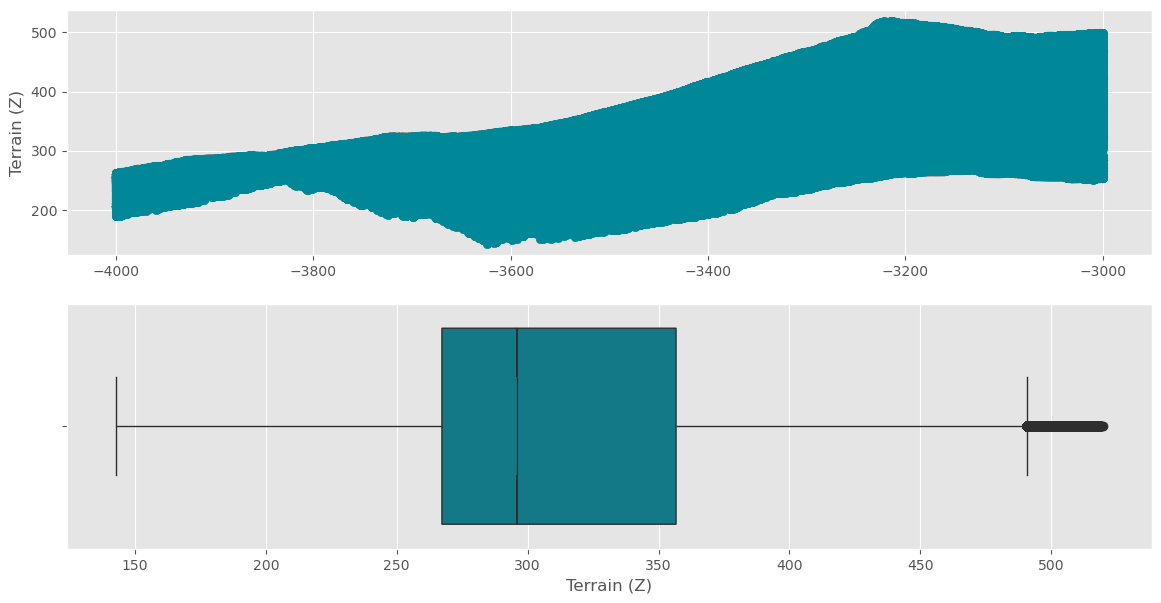

In [87]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 7))

ax[0].scatter(x=df_outlier['X'], y=df_outlier['Z'], c='#008899')
ax[0].set_ylabel('Terrain (Z)')


sns.boxplot(
    x=df_outlier["Z"], 
    color='#008899', 
    notch=True, 
    ax=ax[1]
)
ax[1].set_xlabel('Terrain (Z)');

余程おかしな点は処理できました。
<br><br><br>


## **新たなファイルへの書き込み**
---
最後に、これまでの "Pipeline" 処理に 'データの書き込み' を追加します。

In [101]:
OUT_FILE_PATH = r'../datasets/01ID7913_proj.las'

In [102]:
sentence = \
    {
        "pipeline": [
            {# データの読み込みと、空間参照系の設定
                'type': 'readers.las',
                'filename': IN_FILE_PATH,
                'default_srs': IN_EPSG
            },
            {# 条件式を使用した外れ値の除去
                "type":"filters.expression",
                "expression":"(Z < 600)"
            },
            { # las フォーマットで出力する
                'type': 'writers.las',
                'filename': OUT_FILE_PATH
            }
        ]
    }

pipeline = pdal.Pipeline(json.dumps(sentence))
pipeline.execute()

6684581

## **おわりに**
---
ここまでで、データの読み書きや、外れ値の除去について学んできました。しかし、この程度では実務で使う事は出来ません。GISで使うならば、地形のデータや、地物のデータを作成したいですね。

次の記事では **`DTM（Digital Terrain Model）`** の作成や、その為のアルゴリズムについて簡単に解説しようと思っています。
